# It's Corn (PogChamps \#3) Kaggle Competition - Experiment 6
## Ensembling large models with augmentation sets selected in Experiment 5

In the last experiments we targeted a subset of 3 augmentation sets.  Unfortunately, this didn't perform extremely well on the public leaderboard but lets continue for another couple of steps before we abandon what we found.  We should move to larger models.  Given we have some submissions left today let's try to whip together a quick ensemble of larger models to submit to kaggle.

## Setup Competition Files

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
comp = 'kaggle-pog-series-s01e03'

In [3]:
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')


In [4]:
import timm
from fastai.vision.all import *
set_seed(42)

# path.ls()

In [5]:
trn_path = path/'corn'/'train'
# trn_path.ls()

In [6]:
tst_path = path/'corn'/'test'
# tst_path.ls()

In [7]:
csv_path = path/'corn'
train_csv_fname = csv_path/'train.csv'
trn_files = pd.read_csv(train_csv_fname)
test_csv_fname = csv_path/'test.csv'
tst_files = pd.read_csv(test_csv_fname)
ss_csv_fname = csv_path/'sample_submission.csv'
ss = pd.read_csv(ss_csv_fname)

In [8]:
print(trn_files.head())

   seed_id    view            image       label
0        0     top  train/00000.png      broken
1        1  bottom  train/00001.png        pure
2        3     top  train/00003.png      broken
3        4     top  train/00004.png        pure
4        5     top  train/00005.png  discolored


In [9]:
trn_files['label'].value_counts()

pure          5837
broken        4554
discolored    2504
silkcut       1427
Name: label, dtype: int64

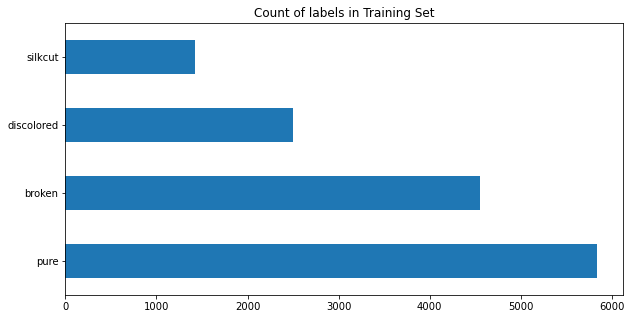

In [10]:
trn_files['label'].value_counts() \
    .plot(kind='barh',
          figsize=(10,5),
          title='Count of labels in Training Set')
plt.show()

In [11]:
def train_accum(arch, batch=aug_transforms(256), item=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border), accum=1, finetune=True, epochs=12, new_seed=42):
    dls = ImageDataLoaders.from_df(trn_files, seed=new_seed,
        path=csv_path, fn_col=2, label_col=3,
        valid_pct=0.2, item_tfms=item,
        batch_tfms=batch,
        bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=accuracy, cbs=cbs).to_fp16()
    _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
    if finetune:
        learn.fine_tune(epochs, _slide)
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, _slide)
    return learn, learn.tta(dl=dls.test_dl(tst_files))

In [12]:
champ_augmentations = {
    'flip_rotate256': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smcrop256': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcropwarp256': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate224': aug_transforms(size=(224,224),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smcrop224': aug_transforms(size=(224,224),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcropwarp224': aug_transforms(size=(224,224),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate192': aug_transforms(size=(192,192),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smcrop192': aug_transforms(size=(192,192),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcropwarp192': aug_transforms(size=(192,192),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
}

In [13]:
models = {
    'convnext_large_in22k': {
        ('flip_rotate256', 11),
        ('flip_rotate_smcrop256', 21),
        ('flip_rotate_smlightcropwarp256', 31),
    }, 'vit_large_patch16_224': {
        ('flip_rotate224', 42),
        ('flip_rotate_smcrop224', 52),
        ('flip_rotate_smlightcropwarp224', 62),
    }, 'swinv2_large_window12_192_22k': {
        ('flip_rotate192', 73),
        ('flip_rotate_smcrop192', 83),
        ('flip_rotate_smlightcropwarp192', 93),
    }, 'swin_large_patch4_window7_224': {
        ('flip_rotate224', 14),
        ('flip_rotate_smcrop224', 24),
        ('flip_rotate_smlightcropwarp224', 34),
    }
}

In [14]:
# import gc

# _epochs = 1
# arch = 'swin_large_patch4_window7_224'
# expts = models[arch]
# for aug, seed in expts:
#     print(aug, " ", seed)
#     learn, tta_res = train_accum(arch, batch=champ_augmentations[aug], item=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border), accum=2, finetune=True, epochs=_epochs, new_seed=seed)
    
#     # Save Model
#     model_filename = f'{arch}-{aug}-seed_{seed}-epochs_{_epochs}-expt_6_test'
#     learn.save(model_filename)
#     learn.export(model_filename+".pkl")
    
#     # Attempt to clear GPU memory (as best we can)
#     del(learn)
#     print(torch.cuda.list_gpu_processes())
#     gc.collect()
#     torch.cuda.empty_cache()
#     break

In [15]:
# # For quick tests
# trn_files = trn_files.sample(100)

--- convnext_large_in22k   flip_rotate_smlightcropwarp256   31 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.979649,0.766201,0.710196,01:18


epoch,train_loss,valid_loss,accuracy,time
0,0.711860,0.657339,0.740922,01:46
1,0.685899,0.598742,0.764316,01:46
2,0.605243,0.556446,0.773394,01:46
3,0.565089,0.551300,0.774441,01:46
4,0.527879,0.530546,0.789804,01:46
5,0.462431,0.528049,0.786662,01:46
6,0.447040,0.523475,0.795042,01:46
7,0.417584,0.520262,0.794693,01:46
8,0.392251,0.523312,0.791201,01:46
9,0.356180,0.518007,0.796788,01:46


GPU:0
process     518485 uses    13305.000 MB GPU memory
--- convnext_large_in22k   flip_rotate_smcrop256   21 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.983042,0.967343,0.670740,01:16


epoch,train_loss,valid_loss,accuracy,time
0,0.637464,0.561040,0.772696,01:45
1,0.618443,0.566843,0.763967,01:45
2,0.587668,0.587595,0.771299,01:45
3,0.559131,0.523272,0.788059,01:45
4,0.508502,0.515475,0.795740,01:45
5,0.413819,0.526599,0.796788,01:45
6,0.415476,0.520609,0.806913,01:44
7,0.307131,0.535424,0.809358,01:45
8,0.266865,0.547288,0.812849,01:45
9,0.195914,0.598688,0.809358,01:45


GPU:0
process     518485 uses    13303.000 MB GPU memory
--- convnext_large_in22k   flip_rotate256   11 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.903915,0.727583,0.710545,01:15


epoch,train_loss,valid_loss,accuracy,time
0,0.680673,0.569486,0.766411,01:44
1,0.608381,0.553160,0.777933,01:44
2,0.586104,0.525416,0.782821,01:44
3,0.550360,0.513137,0.791899,01:44
4,0.496823,0.507058,0.791201,01:44
5,0.466861,0.505048,0.798883,01:44
6,0.405567,0.519234,0.796788,01:44
7,0.372941,0.498939,0.805168,01:44
8,0.317530,0.528009,0.805168,01:44
9,0.259119,0.538762,0.808659,01:44


GPU:0
process     518485 uses    13303.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate224   42 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.990484,0.856230,0.673533,01:31


epoch,train_loss,valid_loss,accuracy,time
0,0.591234,0.679990,0.722416,02:05
1,0.590516,0.631770,0.743017,02:05
2,0.595945,0.665241,0.738827,02:05
3,0.587739,0.650866,0.748254,02:05
4,0.540878,0.596734,0.771648,02:05
5,0.490359,0.581680,0.774791,02:05
6,0.438574,0.592562,0.764316,02:05
7,0.378113,0.585180,0.781075,02:05
8,0.269006,0.656358,0.785265,02:05
9,0.191565,0.719709,0.787011,02:05


GPU:0
process     518485 uses    15983.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate_smlightcropwarp224   62 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.951331,0.761926,0.703212,01:33


epoch,train_loss,valid_loss,accuracy,time
0,0.602295,0.566791,0.779330,02:07
1,0.598659,0.549356,0.781774,02:07
2,0.580636,0.662724,0.734986,02:07
3,0.536843,0.634897,0.770950,02:07
4,0.500929,0.590581,0.760126,02:07
5,0.454643,0.600554,0.776187,02:07
6,0.417370,0.547479,0.794344,02:07
7,0.338548,0.587748,0.800978,02:07
8,0.232372,0.598720,0.799232,02:07
9,0.170117,0.675486,0.800279,02:07


GPU:0
process     518485 uses    15987.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate_smcrop224   52 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.968874,0.707080,0.706006,01:32


epoch,train_loss,valid_loss,accuracy,time
0,0.707990,0.547329,0.769553,02:05
1,0.573637,0.518396,0.782472,02:05
2,0.563937,0.520203,0.786313,02:05
3,0.536906,0.519221,0.787709,02:05
4,0.483396,0.526329,0.782821,02:05
5,0.419887,0.514118,0.798184,02:05
6,0.396463,0.548981,0.777933,02:05
7,0.283928,0.551290,0.802374,02:05
8,0.233623,0.595978,0.798883,02:05
9,0.152401,0.630753,0.803073,02:05


GPU:0
process     518485 uses    15983.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate_smlightcropwarp192   93 ---


/home/speers/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,accuracy,time
0,1.129536,0.747585,0.706704,01:26


epoch,train_loss,valid_loss,accuracy,time
0,0.861126,0.618475,0.753142,01:49
1,0.717903,0.580211,0.768506,01:49
2,0.636108,0.534713,0.782123,01:49
3,0.549261,0.511718,0.796788,01:49
4,0.533813,0.495521,0.799581,01:49
5,0.511883,0.500998,0.797486,01:49
6,0.480519,0.490127,0.797835,01:49
7,0.439332,0.486383,0.803073,01:49
8,0.434842,0.486603,0.803422,01:49
9,0.397130,0.483780,0.809707,01:49


GPU:0
process     518485 uses    14187.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate_smcrop192   83 ---


epoch,train_loss,valid_loss,accuracy,time
0,1.052232,0.871601,0.690642,01:24


epoch,train_loss,valid_loss,accuracy,time
0,0.816137,0.638274,0.754190,01:47
1,0.721794,0.584528,0.772346,01:48
2,0.638995,0.565319,0.781075,01:48
3,0.574603,0.543317,0.784916,01:47
4,0.546561,0.539149,0.793296,01:47
5,0.460505,0.524513,0.798883,01:48
6,0.461596,0.506425,0.806215,01:47
7,0.426404,0.510829,0.800279,01:47
8,0.391217,0.510140,0.795042,01:47
9,0.369722,0.518179,0.798184,01:47


GPU:0
process     518485 uses    14173.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate192   73 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.905448,0.739372,0.713338,01:24


epoch,train_loss,valid_loss,accuracy,time
0,0.688309,0.557339,0.777933,01:47
1,0.601602,0.541653,0.787709,01:47
2,0.573542,0.560250,0.775140,01:47
3,0.574508,0.535080,0.785615,01:47
4,0.516075,0.535480,0.787011,01:47
5,0.482227,0.526057,0.793994,01:47
6,0.419901,0.522345,0.798883,01:47
7,0.391348,0.514273,0.803771,01:47
8,0.316702,0.556511,0.800978,01:47
9,0.275995,0.568699,0.801676,01:47


GPU:0
process     518485 uses    14173.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate224   14 ---


epoch,train_loss,valid_loss,accuracy,time
0,1.056502,0.851494,0.680866,01:14


epoch,train_loss,valid_loss,accuracy,time
0,0.790887,0.668574,0.737779,01:35
1,0.678355,0.616838,0.747207,01:36
2,0.606247,0.561179,0.776885,01:36
3,0.548161,0.529545,0.787360,01:36
4,0.531811,0.506065,0.796439,01:35
5,0.523908,0.505539,0.797486,01:36
6,0.473951,0.503389,0.798184,01:36
7,0.462513,0.495426,0.803771,01:36
8,0.430485,0.491776,0.805866,01:36
9,0.406667,0.495048,0.803073,01:36


GPU:0
process     518485 uses    12603.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate_smcrop224   24 ---


epoch,train_loss,valid_loss,accuracy,time
0,1.062656,0.813401,0.672835,01:14


epoch,train_loss,valid_loss,accuracy,time
0,0.809165,0.633807,0.744413,01:36
1,0.671912,0.597262,0.759777,01:36
2,0.616980,0.542648,0.790154,01:36
3,0.572647,0.582820,0.772346,01:36
4,0.542402,0.513981,0.792249,01:36
5,0.492049,0.498989,0.800978,01:36
6,0.487277,0.475592,0.804818,01:36
7,0.453797,0.488935,0.799581,01:36
8,0.409685,0.489585,0.804469,01:36
9,0.406512,0.479394,0.805517,01:36


GPU:0
process     518485 uses    12603.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate_smlightcropwarp224   34 ---


epoch,train_loss,valid_loss,accuracy,time
0,0.989516,0.765089,0.695880,01:16


epoch,train_loss,valid_loss,accuracy,time
0,0.727185,0.617115,0.752095,01:37
1,0.620125,0.569528,0.768156,01:37
2,0.595092,0.543706,0.787709,01:37
3,0.561010,0.527968,0.786313,01:37
4,0.557902,0.525725,0.794693,01:37
5,0.511901,0.493722,0.804469,01:37
6,0.473210,0.487971,0.795391,01:37
7,0.433198,0.481653,0.813897,01:37
8,0.375995,0.476030,0.820531,01:37
9,0.385019,0.477721,0.820880,01:37


GPU:0
process     518485 uses    12609.000 MB GPU memory


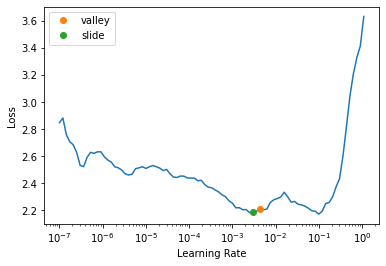

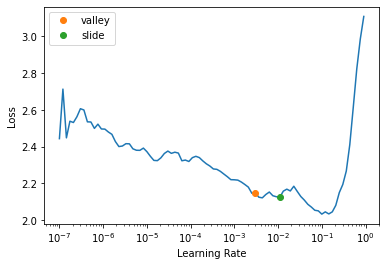

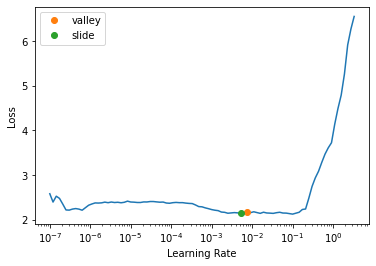

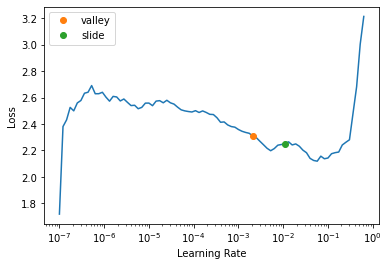

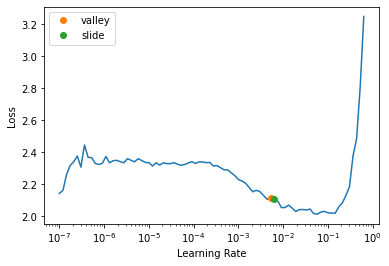

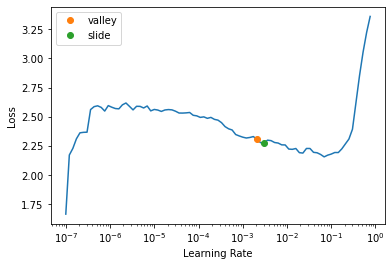

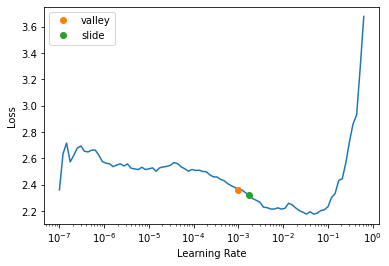

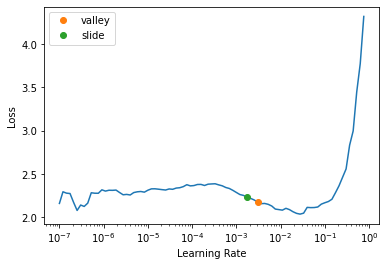

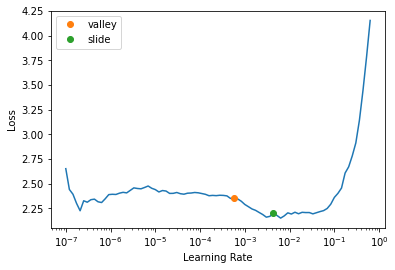

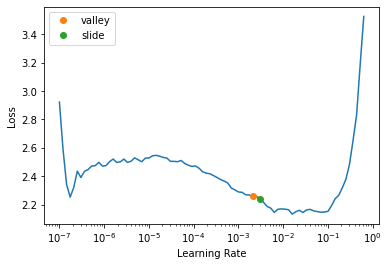

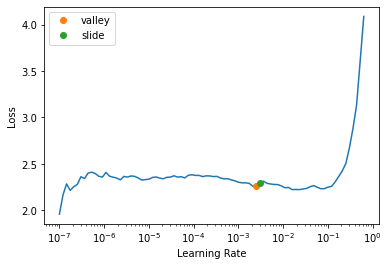

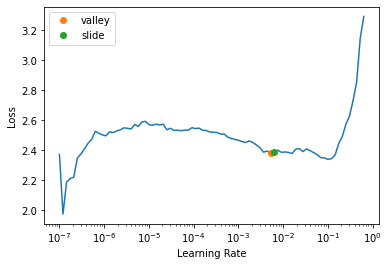

In [16]:
import gc

_item = Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border)
_epochs = 12

tta_res = []
valid_res = []
tta_valid_res = []

for arch, details in models.items():
    for batch, seed in details:
        print('---',arch," ",batch," ",seed,'---')
        learn, tta_out = train_accum(arch, batch=champ_augmentations[batch], item=_item, accum=2, finetune=True, epochs=_epochs, new_seed=seed)
        tta_res.append(tta_out)
        
        # Verify stats on validation set
        valid = learn.dls.valid
        preds,targs = learn.get_preds(dl=valid)
        valid_res.append(accuracy(preds,targs))
        
        # Check TTA statistics on validation set
        tta_preds,targs = learn.tta(dl=valid)
        tta_valid_res.append(accuracy(tta_preds,targs))
        
        # Save Model
        model_filename = f'{arch}-{batch}-seed_{seed}-epochs_{_epochs}-expt_6'
        learn.save(model_filename)
        learn.export(model_filename+".pkl")

        # Attempt to clear GPU memory (as best we can)
        del(learn)
        print(torch.cuda.list_gpu_processes())
        gc.collect()
        torch.cuda.empty_cache()

In [17]:
print(valid_res)
print(tta_valid_res)

[TensorBase(0.7999), TensorBase(0.8080), TensorBase(0.8052), TensorBase(0.7839), TensorBase(0.7957), TensorBase(0.8118), TensorBase(0.8083), TensorBase(0.8017), TensorBase(0.8020), TensorBase(0.7996), TensorBase(0.8083), TensorBase(0.8233)]
[TensorBase(0.8059), TensorBase(0.8135), TensorBase(0.8160), TensorBase(0.7867), TensorBase(0.8128), TensorBase(0.8142), TensorBase(0.8139), TensorBase(0.8059), TensorBase(0.8146), TensorBase(0.8059), TensorBase(0.8163), TensorBase(0.8240)]


This could take a while so let's save the result in case something goes wrong!

In [18]:
save_pickle('tta_res_experiment_6.pkl', tta_res)

## Ensembling

`Learner.tta` returns predictions and targets for each row.  We just want the predictions:

In [19]:
tta_prs = first(zip(*tta_res))

An ensemble simply refers to a model which is itself the result of combining a number of other models.  The simplest way to do ensembling is to take the average of the predictions of each model:

In [20]:
avg_pr = torch.stack(tta_prs).mean(0)
avg_pr.shape

torch.Size([3479, 4])

## Submission
Let's make an example dataloader to generate our vocab:

In [21]:
dls = ImageDataLoaders.from_df(trn_files, seed=21,
    path=csv_path, fn_col=2, label_col=3,
    valid_pct=0.2,
    item_tfms=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border),
    batch_tfms=champ_augmentations['flip_rotate_smcrop256'],
    bs=64//2)

In [22]:
idxs = avg_pr.argmax(dim=1)
idxs

TensorBase([0, 2, 1,  ..., 2, 2, 2])

In [23]:
vocab = np.array(dls.vocab)
vocab

array(['broken', 'discolored', 'pure', 'silkcut'], dtype='<U10')

In [24]:
results = pd.Series(vocab[idxs], name="idxs")
results

0           broken
1             pure
2       discolored
3           broken
4           broken
           ...    
3474    discolored
3475        broken
3476          pure
3477          pure
3478          pure
Name: idxs, Length: 3479, dtype: object

In [26]:
test_csv_fname = csv_path/'test.csv'
test = pd.read_csv(test_csv_fname)
test.head()

,seed_id,view,image
0,2,top,test/00002.png
1,11,bottom,test/00011.png
2,13,top,test/00013.png
3,19,bottom,test/00019.png
4,27,bottom,test/00027.png


In [27]:
test.sort_values(by=['seed_id'])
test = test.drop(columns=['view', 'image'])
test['label'] = results
test

,seed_id,label
0,2,broken
1,11,pure
2,13,discolored
3,19,broken
4,27,broken
...,...,...
3474,17775,discolored
3475,17781,broken
3476,17790,pure
3477,17794,pure


In [28]:
test.to_csv('submission_experiment_6.csv', index=False)
!head submission_experiment_6.csv

seed_id,label
2,broken
11,pure
13,discolored
19,broken
27,broken
30,pure
32,pure
41,pure
42,broken


In [29]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('submission_experiment_6.csv', 'ensemble large models tested augmentation sets', comp)

100%|██████████████████████████████████████| 41.7k/41.7k [00:00<00:00, 59.7kB/s]


Best entry yet!  Accuracy of 81.6% with a rank of 19 on the public leaderboard (including submissions from higher ranking participants that have been deleted by organizer).